In [80]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

## Data import

In [3]:
df = pd.read_csv('pop_data.csv', index_col=0)

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
year = 2010
pop_2010 = df[df.index>'{}-01-01'.format(year)]

In [6]:
pop_2010.index = pop_2010.index.date

In [7]:
pop_ts = list(pop_2010['pop'].values)

In [8]:
pop_2010.shape

(522, 24)

## Single step multilayer perceptron

In [32]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 5

X, y = split_sequence(pop_ts, n_steps)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=2000, verbose=0)

In [88]:
def collect_row(data, prediction):
    new_row = np.append(data[-1,1:],prediction)
    return new_row

In [89]:
def prediction(data, row):
    x_input = np.array(X[row,:])
    row = x_input.reshape((1, n_steps))
    return model.predict(row, verbose=0)[0][0]

In [118]:
num_preds = 10
predictions_array = X.copy()
for i in range(num_preds):
    predictions_array = np.append(predictions_array,
                                  collect_row(predictions_array, prediction(predictions_array,-1)).reshape(1,5),
                                  axis=0)

# Multistep Univariate Multilayer perceptron

In [334]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [342]:
n_steps_in, n_steps_out = 3, 100

X, y = split_sequence(pop_ts, n_steps_in, n_steps_out)

In [343]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=2000, verbose=0);

In [344]:
x_input = X[-1,:]
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)

In [345]:
ts = pd.DataFrame(pop_ts, columns=['ts'])
preds = pd.DataFrame(yhat).T.rename(columns={0:'ts'})

In [346]:
preds.index = [i+(ts.index.stop) for i in range(preds.shape[0])]

In [347]:
connector = pd.DataFrame(
    np.append(
        (preds.head(1).reset_index().values)[0].reshape(2,1),
        (ts.tail(1).reset_index().values)[0].reshape(2,1),
        axis=1)).T.set_index(0)

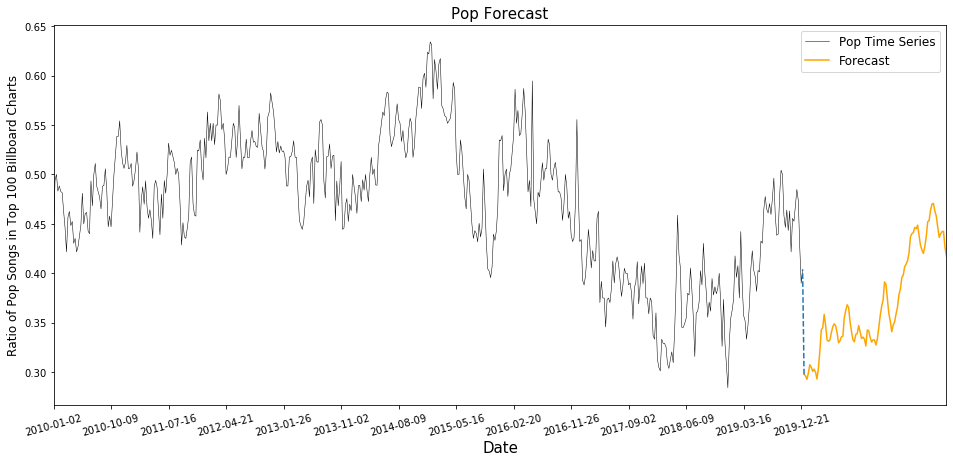

In [348]:
fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts.plot(ax=ax, lw=0.5, color='black')
preds.plot(ax=ax, color='orange')
connector.plot(ax=ax, style='--')

plt.title('Pop Forecast', fontsize=15)
plt.legend(('Pop Time Series', 'Forecast'), loc='best', fontsize=12)
plt.xticks(ticks=[i for i in range(pop_2010.shape[0])][::40], labels=list(pop_2010.index)[::40], rotation=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio of Pop Songs in Top 100 Billboard Charts', fontsize=12)
plt.show()

## With cross validation

In [ ]:
pop_ts = list(pop_2010['pop'].values)

In [411]:
split = 0.75
train = pop_ts[0:int(len(pop_ts)*split)]
test = pop_ts[int(len(pop_ts)*split):-1]

In [431]:
n_steps_in, n_steps_out = 5, len(test)

X, y = split_sequence(train, n_steps_in, n_steps_out)

model = Sequential()
model.add(Dense(150, activation='relu', input_dim=n_steps_in)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=3000, verbose=0, use_multiprocessing=True);

In [432]:
x_input = X[-1,:]
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)

ts = pd.DataFrame(train, columns=['ts'])
preds = pd.DataFrame(yhat).T.rename(columns={0:'ts'})
test = pd.DataFrame(test, columns=['ts'])

preds.index = [i+(ts.index.stop) for i in range(preds.shape[0])]
test.index = preds.index

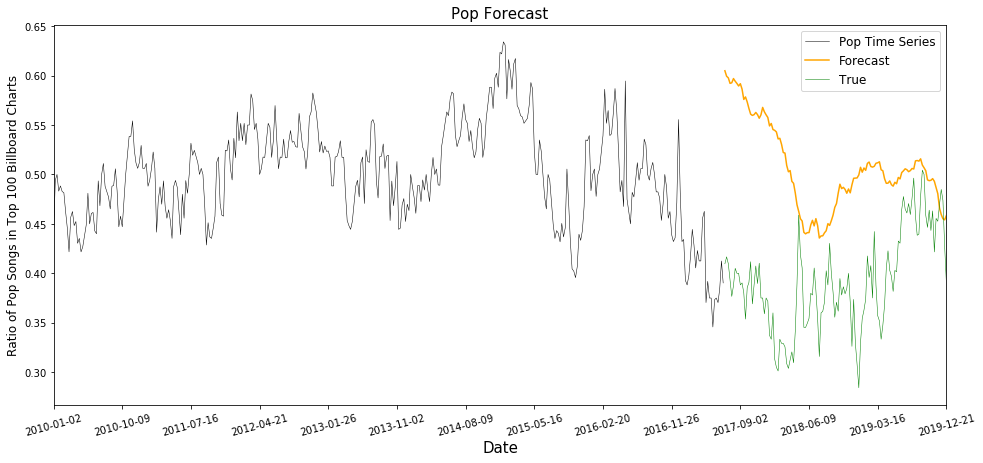

In [433]:
connector = pd.DataFrame(
    np.append(
        (preds.head(1).reset_index().values)[0].reshape(2,1),
        (ts.tail(1).reset_index().values)[0].reshape(2,1),
        axis=1)).T.set_index(0)

fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts.plot(ax=ax, lw=0.5, color='black')
preds.plot(ax=ax, color='orange')
test.plot(ax=ax, color='green', lw=0.5)

plt.title('Pop Forecast', fontsize=15)
plt.legend(('Pop Time Series', 'Forecast', 'True'), loc='best', fontsize=12)
plt.xticks(ticks=[i for i in range(pop_2010.shape[0])][::40], labels=list(pop_2010.index)[::40], rotation=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio of Pop Songs in Top 100 Billboard Charts', fontsize=12)
plt.show()

## Deep convolutional network

In [438]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [444]:
import tensorflow.keras.layers

In [454]:
n_steps_in, n_steps_out = 3, len(test)

X, y = split_sequence(train, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(tensorflow.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(tensorflow.keras.layers.MaxPooling1D())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=2000, verbose=0)

x_input = X[-1,:]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

ts = pd.DataFrame(train, columns=['ts'])
preds = pd.DataFrame(yhat).T.rename(columns={0:'ts'})
test = pd.DataFrame(test, columns=['ts'])

preds.index = [i+(ts.index.stop) for i in range(preds.shape[0])]
test.index = preds.index

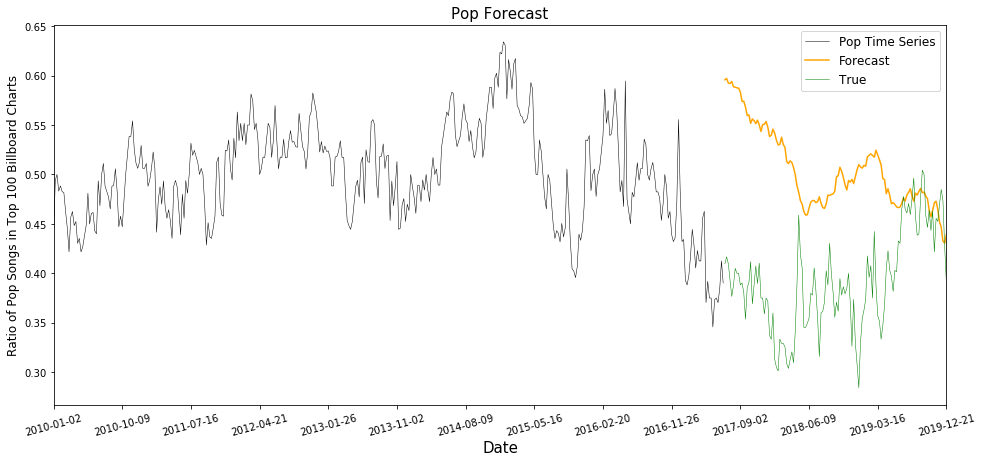

In [455]:
connector = pd.DataFrame(
    np.append(
        (preds.head(1).reset_index().values)[0].reshape(2,1),
        (ts.tail(1).reset_index().values)[0].reshape(2,1),
        axis=1)).T.set_index(0)

fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts.plot(ax=ax, lw=0.5, color='black')
preds.plot(ax=ax, color='orange')
test.plot(ax=ax, color='green', lw=0.5)

plt.title('Pop Forecast', fontsize=15)
plt.legend(('Pop Time Series', 'Forecast', 'True'), loc='best', fontsize=12)
plt.xticks(ticks=[i for i in range(pop_2010.shape[0])][::40], labels=list(pop_2010.index)[::40], rotation=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio of Pop Songs in Top 100 Billboard Charts', fontsize=12)
plt.show()

## LSTM modelling

In [462]:
n_steps_in, n_steps_out = 5, len(test)

X, y = split_sequence(train, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(tensorflow.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in,
n_features)))
model.add(tensorflow.keras.layers.LSTM(100, activation='relu')) 
model.add(Dense(n_steps_out)) 
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, verbose=0)

x_input = X[-1,:]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

ts = pd.DataFrame(train, columns=['ts'])
preds = pd.DataFrame(yhat).T.rename(columns={0:'ts'})
test = pd.DataFrame(test, columns=['ts'])

preds.index = [i+(ts.index.stop) for i in range(preds.shape[0])]
test.index = preds.index

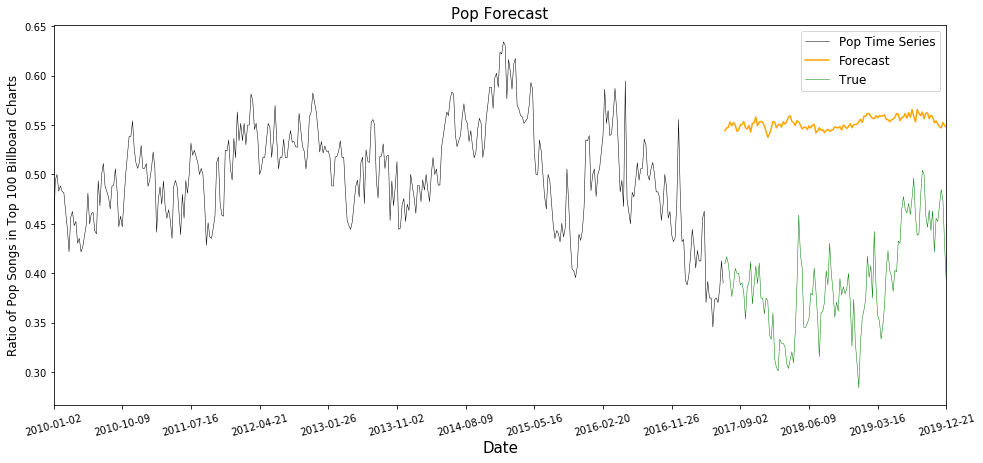

In [463]:
connector = pd.DataFrame(
    np.append(
        (preds.head(1).reset_index().values)[0].reshape(2,1),
        (ts.tail(1).reset_index().values)[0].reshape(2,1),
        axis=1)).T.set_index(0)

fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts.plot(ax=ax, lw=0.5, color='black')
preds.plot(ax=ax, color='orange')
test.plot(ax=ax, color='green', lw=0.5)

plt.title('Pop Forecast', fontsize=15)
plt.legend(('Pop Time Series', 'Forecast', 'True'), loc='best', fontsize=12)
plt.xticks(ticks=[i for i in range(pop_2010.shape[0])][::40], labels=list(pop_2010.index)[::40], rotation=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio of Pop Songs in Top 100 Billboard Charts', fontsize=12)
plt.show()

In [476]:
n_steps_in, n_steps_out = 5, len(test)

X, y = split_sequence(train, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))


model = Sequential()
model.add(tensorflow.keras.layers.LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(tensorflow.keras.layers.RepeatVector(n_steps_out))
model.add(tensorflow.keras.layers.LSTM(100, activation='relu', return_sequences=True)) 
model.add(tensorflow.keras.layers.TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=50, verbose=0)

x_input = X[-1,:]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

In [477]:

ts = pd.DataFrame(train, columns=['ts'])
preds = pd.DataFrame(yhat[0]).rename(columns={0:'ts'})
test = pd.DataFrame(test, columns=['ts'])

preds.index = [i+(ts.index.stop) for i in range(preds.shape[0])]

In [478]:
test.index = preds.index

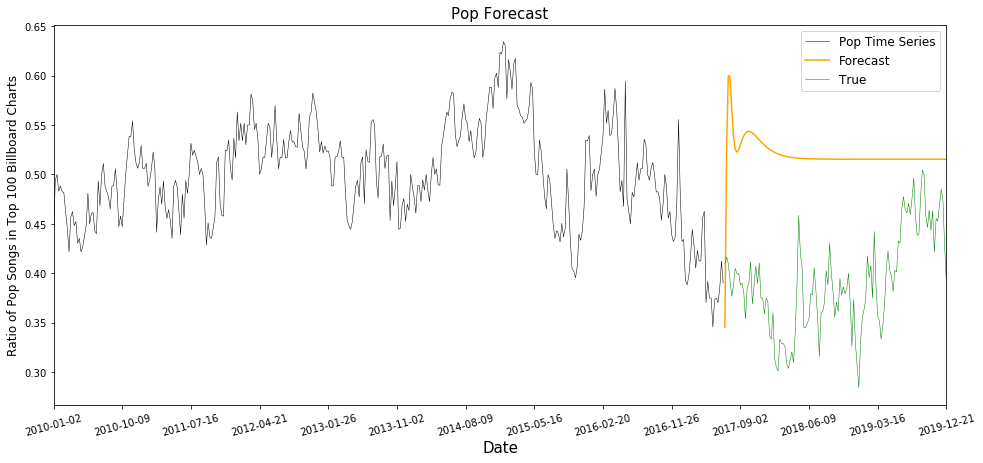

In [479]:
connector = pd.DataFrame(
    np.append(
        (preds.head(1).reset_index().values)[0].reshape(2,1),
        (ts.tail(1).reset_index().values)[0].reshape(2,1),
        axis=1)).T.set_index(0)

fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts.plot(ax=ax, lw=0.5, color='black')
preds.plot(ax=ax, color='orange')
test.plot(ax=ax, color='green', lw=0.5)

plt.title('Pop Forecast', fontsize=15)
plt.legend(('Pop Time Series', 'Forecast', 'True'), loc='best', fontsize=12)
plt.xticks(ticks=[i for i in range(pop_2010.shape[0])][::40], labels=list(pop_2010.index)[::40], rotation=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio of Pop Songs in Top 100 Billboard Charts', fontsize=12)
plt.show()

## Exponential Smoothing

In [9]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [33]:
ses_data = pop_2010[['pop']]

In [37]:
ses_data.index = pd.to_datetime(ses_data.index)

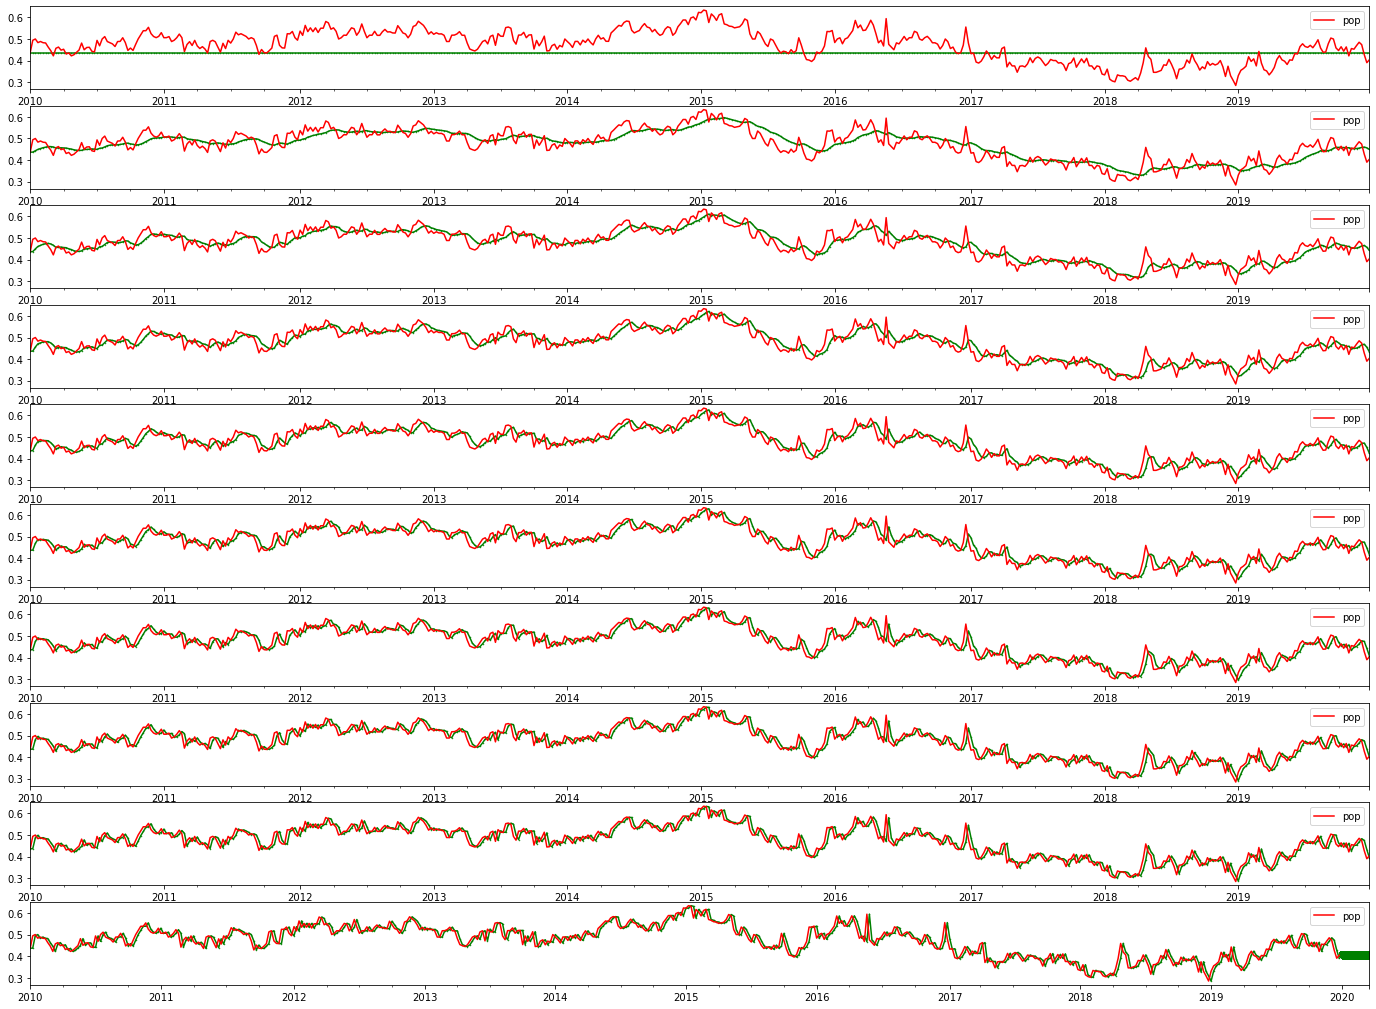

In [86]:
# Simple Exponential Smoothing
alpha_values = np.linspace(0,1,10)
fig, ax = plt.subplots(figsize=(24,18), nrows=len(alpha_values))

for i,alpha in enumerate(alpha_values):
    fit = SimpleExpSmoothing(ses_data).fit(smoothing_level=alpha, optimized=False)
    fcast = fit1.forecast(12).rename(r'$\alpha={}$'.format(alpha))
    fcast.plot(marker='o', color='g')
    fit.fittedvalues.plot(marker='o',  color='g', ax=ax[i], ms=0.5)
    ses_data.plot(ax=ax[i], color='red')

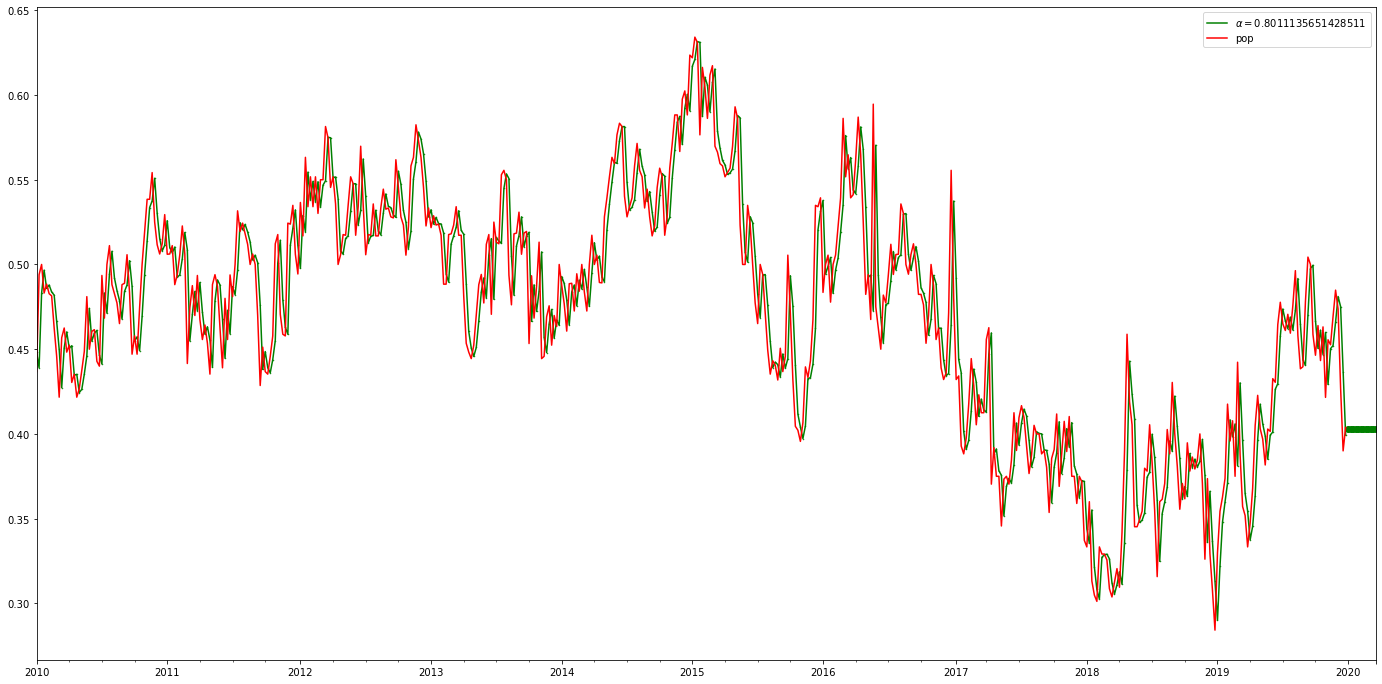

In [94]:
fig, ax = plt.subplots(figsize=(24,12))
fit = SimpleExpSmoothing(ses_data).fit()
fcast = fit.forecast(12).rename(r'$\alpha=%s$'%fit.model.params['smoothing_level'])
fcast.plot(marker='o', color='g', legend=True)
fit.fittedvalues.plot(marker='o',  color='g', ax=ax, ms=0.5)
ses_data.plot(ax=ax, color='red')
fig.show()

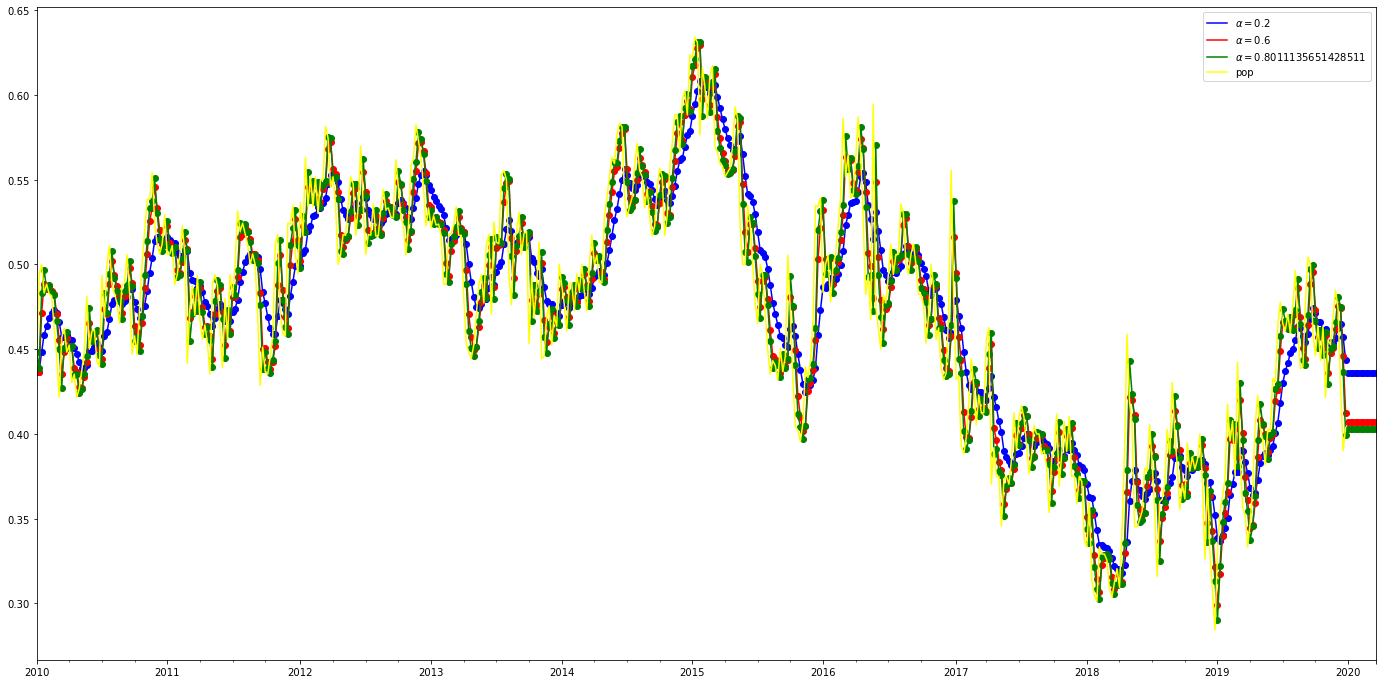

In [88]:
# Simple Exponential Smoothing
fig, ax = plt.subplots(figsize=(24,12))

fit1 = SimpleExpSmoothing(ses_data).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')

fit2 = SimpleExpSmoothing(ses_data).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


fit3 = SimpleExpSmoothing(ses_data).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

ses_data.plot(ax=ax, color='yellow')

plt.show()

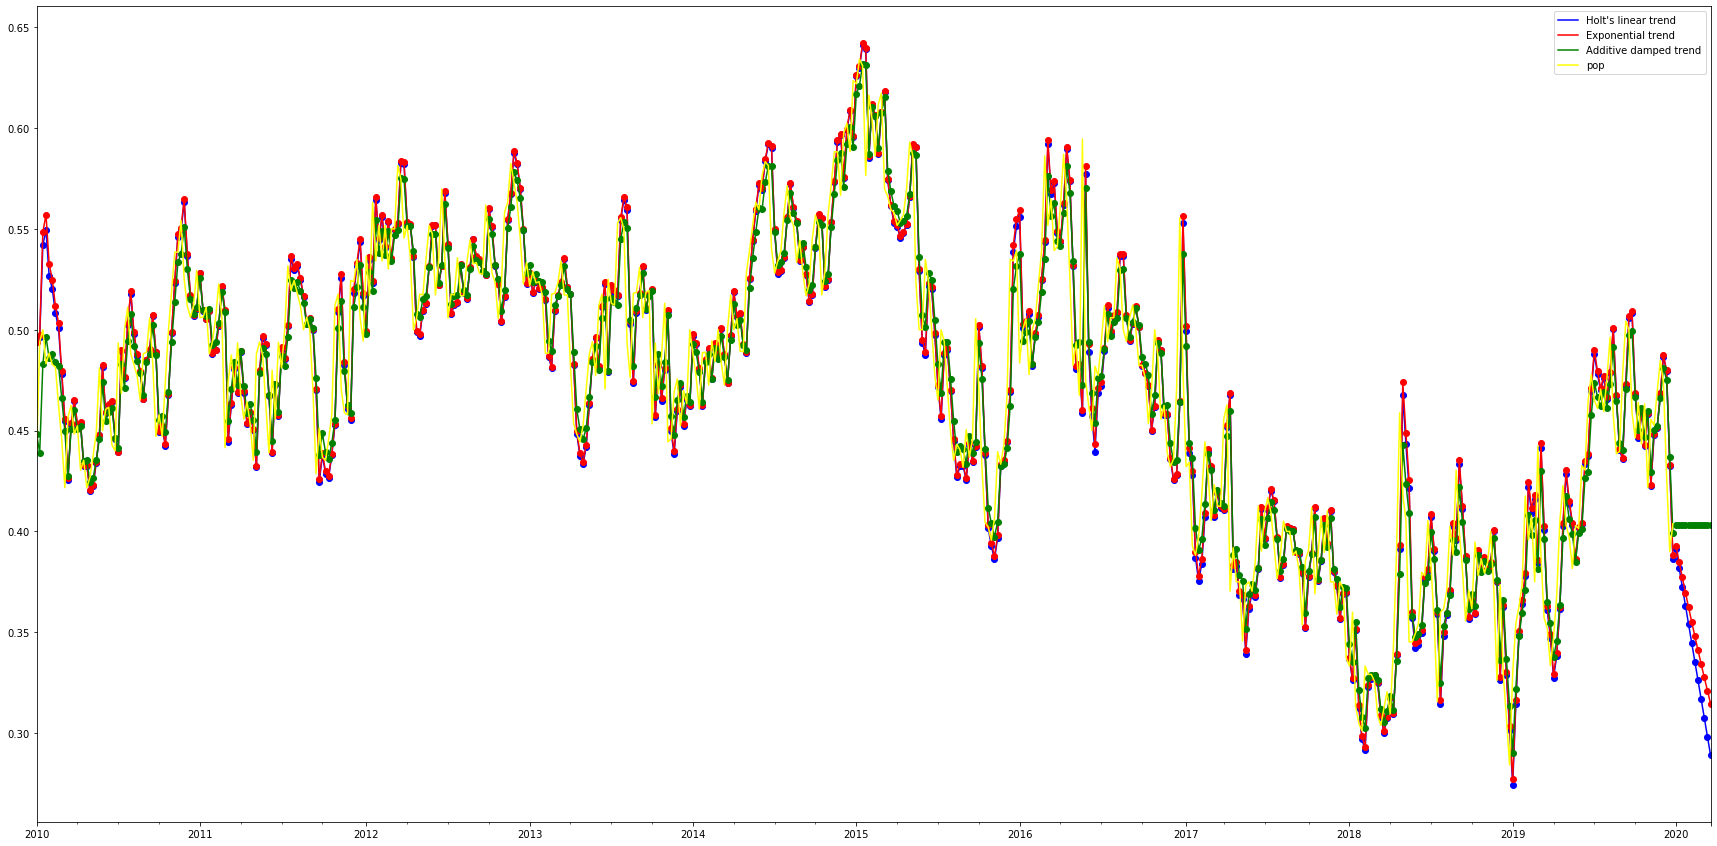

In [89]:
fig, ax = plt.subplots(figsize=(30,15))
fit1 = Holt(ses_data).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(ses_data, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(ses_data, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")


fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

ses_data.plot(ax=ax, color='yellow')

plt.show()

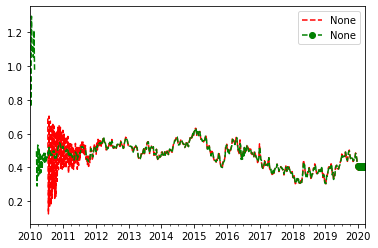

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.


In [90]:
# Seasoality
fit1 = ExponentialSmoothing(ses_data, seasonal_periods=2, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(ses_data, seasonal_periods=2, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(ses_data, seasonal_periods=2, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(ses_data, seasonal_periods=2, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

fit1.forecast(12).plot(style='--', marker='o', color='red', legend=True)
fit2.forecast(12).plot(style='--', marker='o', color='green', legend=True)

plt.show()
print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")